In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import loadtxt
from logistic_regression import *
import matplotlib.pyplot as plt
import scipy.optimize as opt

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "y",
          "axes.facecolor" : "None",
          "text.color" : 'w'}
plt.rcParams.update(params)

# <center><font color=slate>Logistic Regression</font></center>
## <center><font color=tomato>1. Logistic Regression</font></center>
Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams.
You have historical data from previous applicants that you can use as a training set for logistic regression.
For each training example, you have the applicant's scores on two exams and the admissions decision.

In [2]:
data = loadtxt("data/ex2data1.txt", delimiter=",")
X = data[:, :2]; y = data[:, -1]

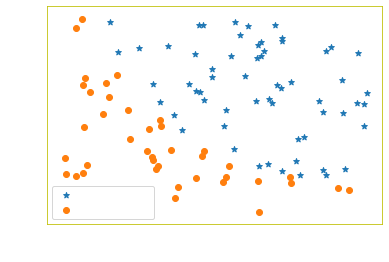

In [3]:
plot_scatter(X, y, label_y1='Admitted', label_y2='Not admitted')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend();

### <font color=lightGreen>1.2 Implementation</font>
### 1.2.1 Sigmoid function

<center>

$$h_θ(x) = g(θ^Tx)$$</center>

where function $g$ is the sigmoid function. The sigmoid function is defined as:
<center>

$$g(z) = \frac{1} {1 + e^{-z}}$$</center>

In [4]:
z = np.array([-1, 0, 1])
sigmoid(z=z)

array([0.26894142, 0.5       , 0.73105858])

### 1.2.2 Cost function and gradient


Cost function in logistic regression
<center>

$$J(θ) = \frac{1}{m}  \sum_{i=1}^m [-y^{(i)} log(h_θ(x^{(i)})) - (1 - y^{(i)}) log (1 - h_θ(x^{(i)}))]$$
</center>


and the gradient of the cost is a vector of the same length as  where the th element (for $j = 0, 1, .., n$) is defined as follows:
<center>

$$\frac {𝜕J(θ)} {𝜕θ_j} = \frac{1}{m} \sum_{i=1}^m (h_θ(x^{(i)})-y^{(i)})x^{(i)}_j$$ </center>


In [5]:
m, n = X.shape
X = np.hstack((np.ones((m, 1)), X))
initial_theta = np.zeros(shape=(n+1))

In [6]:
J, grad = cost_function(initial_theta, X, y)
print(f'Cost at initial theta (zeros): {J:.4f}')
print(f'Gradient at initial theta (zeros):\n {grad}')


Cost at initial theta (zeros): 0.6931
Gradient at initial theta (zeros):
 [ -0.1        -12.00921659 -11.26284221]


### 1.2.3 Learning parameters using `fmin_bfgs`

Now to find the minimum of this cost function, we will use a scipy built-in function called `minimize`.
It will find the best parameters theta for the logistic regression cost function given a fixed dataset (of X and Y values).

The parameters are:
-   A function that, when given the training set and a particular theta,
computes the logistic regression cost with respect to theta for the dataset (X,y).
=   A similar function that computes gradient
-   The initial values of the parameters you are trying to optimize;

The final theta value will then be used to plot the decision boundary on the training data.

In [7]:
result = opt.minimize(cost_function, x0=initial_theta, args=(X, y), method="TNC", jac=True)
J_opt = result.fun
theta_opt = result.x
print(f'Cost at theta found by TNC: {J_opt:.4f}')
print(f'theta found by TNC:\n {theta_opt}')

Cost at theta found by TNC: 0.2035
theta found by TNC:
 [-25.1613187    0.20623159   0.20147149]


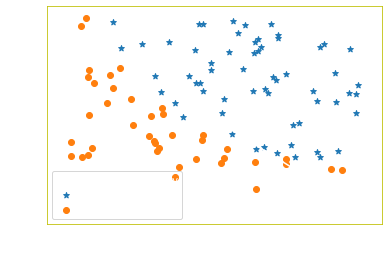

In [8]:
plot_scatter(X[:, 1:], y, label_y1='Admitted', label_y2='Not admitted')
plot_x = np.array([min(X[:, 1]) - 2, max(X[:, 1]) + 2]) # Only need 2 points to define a line, so choose two endpoints
plot_y = (-1 / theta_opt[2]) * (theta_opt[1] * plot_x + theta_opt[0]) # Calculate the decision boundary line
plt.plot(plot_x, plot_y, label='Decision Boundary', c='w') # Plot, and adjust axes for better viewing
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend();

### 1.2.4 Evaluating logistic regression
After learning the parameters, you can use the model to predict whether a particular student will be admitted.
For a student with an Exam 1 score of 45 and an Exam 2 score of 85, you should expect to see an admission probability of 0.776.


In [9]:
prob = sigmoid(np.array([1, 45, 85]) @ theta_opt.reshape(-1,1))
print(f'For a student with scores 45 and 85, we predict an admission probability of {(prob[0]*100):.2f}%')

For a student with scores 45 and 85, we predict an admission probability of 77.63%


Another way to evaluate the quality of the parameters we have found is to see how well the learned model predicts on our training set.
The `predict()` function will produce '1' or '0' predictions given a dataset and a learned parameter vector .
The code below will proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct.


In [10]:
p = prediction_accuracy(X, y, theta_opt)
print(f'Train Accuracy: {p}%')

Train Accuracy: 89%


## <center><font color=tomato>2. Regularized logistic regression</font></center>
We will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA).
During QA, each microchip goes through various tests to ensure it is functioning correctly.
From these two tests, you would like to determine whether the microchips should be accepted or rejected.
To help you make the decision, you have a dataset of test results on past microchips,
from which you can build a logistic regression model.
### <font color=lightGreen>2.1 Visualizing the data</font>


In [11]:
data = loadtxt("data/ex2data2.txt", delimiter=",")
X = data[:, :2]; y = data[:, -1]

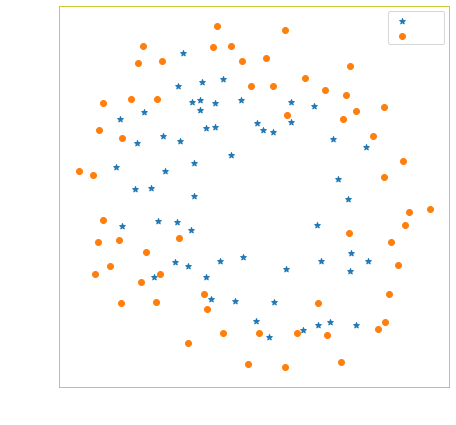

In [12]:
plt.figure(figsize=(7,7))
plot_scatter(X, y, label_y1='y=1', label_y2='y=0')
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend();

Figure 3 shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot.
Therefore, a straightforward application of logistic regression will not perform well on this dataset
since logistic regression will only be able to find a linear decision boundary.

### <font color=lightGreen>2.2 Feature mapping</font>
One way to fit the data better is to create more features from each data point. In the provided function mapFeature(),
we will map the features into all polynomial terms of  and  up to the sixth power.

<center>

\begin{equation*}
mapFeature(x) =
\begin{vmatrix}
1 \\
x_1\\
x_2\\
x^2_1\\
x_1x_2\\
x^2_2\\
x^3_1\\
⠇\\
x_1x^5_2\\
x^6_2\\
\end{vmatrix}
\end{equation*}
</center>

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector.

A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.

In [13]:
X.shape

(118, 2)

In [14]:
degree = 6
map_feature_X = map_feature(x1=X[:, 0],x2=X[:, 1], degree=degree)
map_feature_X.shape

(118, 28)

### <font color=lightGreen></font>
`cost_function_gradient_reg()` returns the cost and gradient.
Regularized cost function in logistic regression:

<center>

$$J(θ) = \frac{1}{m}  \sum_{i=1}^m [-y^{(i)} log(h_θ(x^{(i)})) - (1 - y^{(i)}) log (1 - h_θ(x^{(i)}))] + \frac{λ}{2m}\sum_{j=1}^nθ^2_{j'}$$
</center>


Note that you should not regularize the parameter $θ_0$.
The gradient of the cost function is a vector where the $jth$ element is defined as follows:


<center>

$$\frac {𝜕J(θ)} {𝜕θ_j} = \frac{1}{m} \sum_{i=1}^m (h_θ(x^{(i)})-y^{(i)})x^{(i)}_j$$   for j = 0

$$\frac {𝜕J(θ)} {𝜕θ_j} = \frac{1}{m} \sum_{i=1}^m (h_θ(x^{(i)})-y^{(i)})x^{(i)}_j + \frac{λ}{m} θ_j$$   for j>= 1
</center>


In [15]:
initial_theta = np.zeros((map_feature_X.shape[1]))
Lambda = 0.1
J, grad = cost_function_gradient_reg(initial_theta, map_feature_X, y, Lambda)
print(f'Cost at initial theta (zeros): {J:.4f}')

Cost at initial theta (zeros): 0.6931


### <font color=lightGreen>2.4 Plotting the decision boundary</font>
Using the scipy built-in function `fmin_tnc`

In [16]:
%%time
result = opt.minimize(cost_function_gradient_reg, x0=initial_theta, args=(map_feature_X, y, Lambda), method="BFGS", jac=True)

CPU times: user 10.9 ms, sys: 1.24 ms, total: 12.1 ms
Wall time: 11.1 ms


In [17]:
theta_opt = result.x


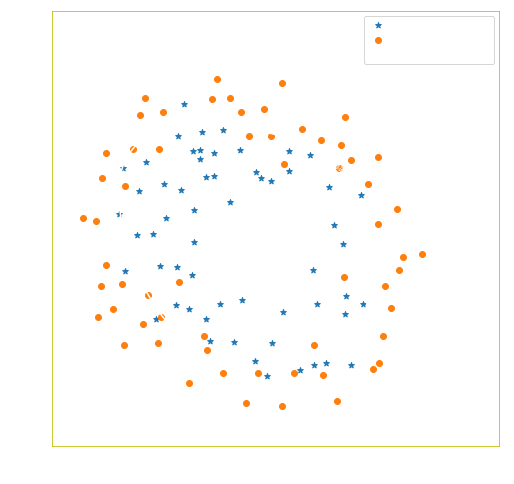

In [18]:
def plot_decision_bundary(X, y, theta):
    u_vals = np.linspace(-1,1.5,50)
    v_vals= np.linspace(-1,1.5,50)
    z=np.zeros((len(u_vals),len(v_vals)))
    for i in range(len(u_vals)):
        for j in range(len(v_vals)):
            z[i,j] = map_feature(u_vals[i],v_vals[j],degree) @ theta
    plt.figure(figsize=(8, 8))
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plot_scatter(X, y, label_y1='y=1', label_y2='y=0')
    CS = plt.contour(u_vals,v_vals,z.T,0,colors='w')
    plt.clabel(CS, inline=1, fontsize=8, fmt= 'Decision boundary')
    CS.collections[0].set_label('Decision boundary')
    plt.legend();

plot_decision_bundary(X, y, theta_opt)

In [19]:
p = prediction_accuracy(map_feature_X, y, theta_opt)
print(f'Train Accuracy: {p}%')

Train Accuracy: 98%


### Using gradient descent


In [20]:
%%time
theta_opt, J = gradient_descent(map_feature_X, y, initial_theta, alpha=1, num_iters=800, Lambda=Lambda)

CPU times: user 27.6 ms, sys: 750 µs, total: 28.3 ms
Wall time: 27.6 ms


Train Accuracy: 89%


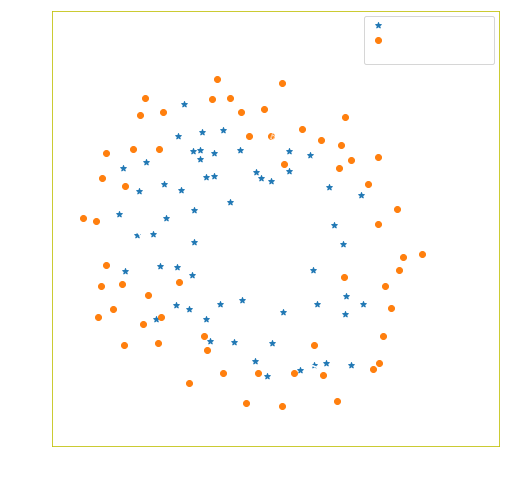

In [21]:
plot_decision_bundary(X, y, theta_opt)
p = prediction_accuracy(map_feature_X, y, theta_opt)
print(f'Train Accuracy: {p}%')

### Using normal equation

Train Accuracy: 69%


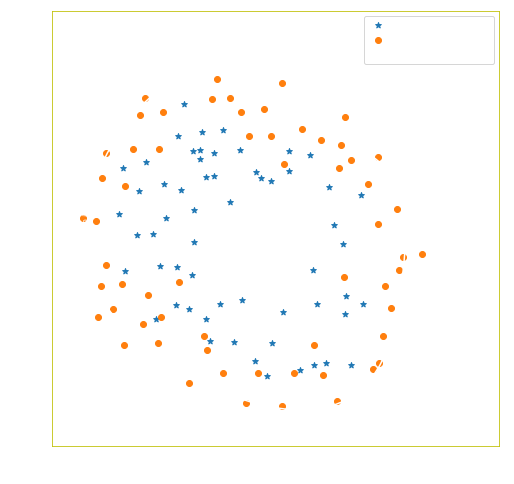

In [22]:
theta_opt = normal_equation_reg(map_feature_X, y, Lambda=0.05)
plot_decision_bundary(X, y, theta_opt)
p = prediction_accuracy(map_feature_X, y, theta_opt)
print(f'Train Accuracy: {p}%')
